In [ ]:
from astropy.io import fits, ascii
import numpy as np
import matplotlib.pyplot as plt
import define_rgbsample
import glob
import os
import re
import multiprocessing
import tqdm 

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)


params = {'axes.labelsize': 14, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'text.usetex': True, 'lines.linewidth': 1,
          'axes.titlesize': 14, 'font.family': 'serif'}
plt.rcParams.update(params)

columnwidth = 240./72.27
textwidth = 504.0/72.27


orbitcat = fits.open('/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams.fits')[1].data

print('loading Gaia RV cat...')
files = glob.glob('/gal/GAIA/gdr2/gaia_source_with_rv/csv/*')

files = natural_sort(files)

def readfile(i):
    return ascii.read(files[i])

with multiprocessing.Pool(8) as p:
    chunks = list(tqdm.tqdm(p.imap(readfile, range(len(files))), total=len(files)))

source_ids = np.concatenate([np.array(chunks[i])['source_id'] for i in range(len(chunks))])

ra = np.concatenate([chunks[i]['ra'].filled(np.nan) for i in range(len(chunks))])
dec = np.concatenate([chunks[i]['dec'].filled(np.nan) for i in range(len(chunks))])
parallax = np.concatenate([chunks[i]['parallax'].filled(np.nan) for i in range(len(chunks))])
pmra = np.concatenate([chunks[i]['pmra'].filled(np.nan) for i in range(len(chunks))])
pmdec =  np.concatenate([chunks[i]['pmdec'].filled(np.nan) for i in range(len(chunks))])
rv = np.concatenate([chunks[i]['radial_velocity'].filled(np.nan) for i in range(len(chunks))])


ra_err = np.concatenate([chunks[i]['pmra_error'].filled(np.nan) for i in range(len(chunks))])
dec_err =  np.concatenate([chunks[i]['pmdec_error'].filled(np.nan) for i in range(len(chunks))])
parallax_err = np.concatenate([chunks[i]['parallax_error'].filled(np.nan) for i in range(len(chunks))])
pmra_err = np.concatenate([chunks[i]['pmra_error'].filled(np.nan) for i in range(len(chunks))])
pmdec_err =  np.concatenate([chunks[i]['pmdec_error'].filled(np.nan) for i in range(len(chunks))])
rv_err = np.concatenate([chunks[i]['radial_velocity_error'].filled(np.nan) for i in range(len(chunks))])
ra_dec_corr = np.concatenate([chunks[i]['ra_dec_corr'].filled(np.nan) for i in range(len(chunks))])
ra_parallax_corr= np.concatenate([chunks[i]['ra_parallax_corr'].filled(np.nan) for i in range(len(chunks))])
ra_pmra_corr = np.concatenate([chunks[i]['ra_pmra_corr'].filled(np.nan) for i in range(len(chunks))])
ra_pmdec_corr = np.concatenate([chunks[i]['ra_pmdec_corr'].filled(np.nan) for i in range(len(chunks))])
dec_parallax_corr= np.concatenate([chunks[i]['dec_parallax_corr'].filled(np.nan) for i in range(len(chunks))])
dec_pmra_corr = np.concatenate([chunks[i]['dec_pmra_corr'].filled(np.nan) for i in range(len(chunks))])
dec_pmdec_corr = np.concatenate([chunks[i]['dec_pmdec_corr'].filled(np.nan) for i in range(len(chunks))])
parallax_pmra_corr = np.concatenate([chunks[i]['parallax_pmra_corr'].filled(np.nan) for i in range(len(chunks))])
parallax_pmdec_corr =  np.concatenate([chunks[i]['parallax_pmdec_corr'].filled(np.nan) for i in range(len(chunks))])
pmra_pmdec_corr =  np.concatenate([chunks[i]['pmra_pmdec_corr'].filled(np.nan) for i in range(len(chunks))])

covariance = np.zeros([len(ra),6,6])
covariance[:,0,0] = ra_err**2
covariance[:,1,1] = dec_err**2
covariance[:,2,2] = parallax_err**2
covariance[:,3,3] = pmra_err**2
covariance[:,4,4] = pmdec_err**2
covariance[:,5,5] = rv_err**2
covariance[:,0,1] = ra_dec_corr*ra_err*dec_err
covariance[:,0,2] = ra_parallax_corr*ra_err*parallax_err
covariance[:,0,3] = ra_pmra_corr*ra_err*pmra_err
covariance[:,0,4] = ra_pmdec_corr*ra_err*pmdec_err
covariance[:,1,0] = covariance[:,0,1]
covariance[:,1,2] = dec_parallax_corr*dec_err*parallax_err
covariance[:,1,3] = dec_pmra_corr*dec_err*pmra_err
covariance[:,1,4] = dec_pmdec_corr*dec_err*pmdec_err
covariance[:,2,0] = covariance[:,0,2]
covariance[:,2,1] = covariance[:,1,2]
covariance[:,2,3] = parallax_pmra_corr*parallax_err*pmra_err
covariance[:,2,4] = parallax_pmdec_corr*parallax_err*pmdec_err
covariance[:,3,0] = covariance[:,0,3]
covariance[:,3,1] = covariance[:,1,3]
covariance[:,3,2] = covariance[:,2,3]
covariance[:,3,4] = pmra_pmdec_corr*pmra_err*pmdec_err
covariance[:,4,0] = covariance[:,0,4]
covariance[:,4,1] = covariance[:,1,4]
covariance[:,4,2] = covariance[:,2,4]
covariance[:,4,3] = covariance[:,3,4]

sXYZ, svxyz, sRpz, svRvTvz = define_rgbsample.obs_to_galcen(ra, 
                                                            dec, 
                                                            1/parallax, 
                                                            pmra, 
                                                            pmdec, 
                                                            rv, 
                                                            pmra_err, 
                                                            pmdec_err, 
                                                            pmra_pmdec_corr, 
                                                            parallax_err, 
                                                            rv_err,
                                                            return_cov = False,
                                                            verbose = True,
                                                            return_rphiz = True,
                                                            ro = 8.,
                                                            vo = 220.,
                                                            zo = 0.025,
                                                            parallax=False)

mask = (parallax/parallax_err > 20) & (orbitcat['rap']/orbitcat['rap_err'] > 20) & (np.isfinite(orbitcat['rperi']))

centers = np.linspace(2,8,360)

8.721309192200557
9.121309192200558
8.621309192200558
9.221309192200557
/home/astjmack/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10

8.721309192200557
9.121309192200558
/home/astjmack/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10



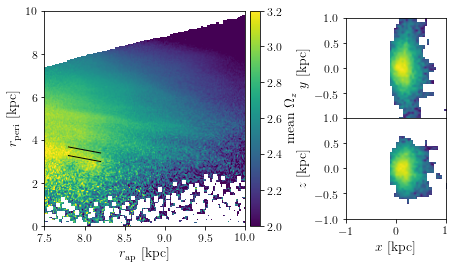

In [7]:
def one_frame(i):    
    fig = plt.figure()
    fig.set_size_inches(textwidth,columnwidth)
    ax = fig.add_axes([0.1,0.1,0.4,0.9])
    cax = fig.add_axes([0.51,0.1,0.02,0.9])
    xmin, xmax = 7.5, 10.
    ymin, ymax = 0., 10.
    xbins = np.linspace(xmin, xmax,200)
    ybins = np.linspace(ymin ,ymax,200)
    fin = np.isfinite(orbitcat['e']) & np.isfinite(orbitcat['omega_z'])
    hist, yedges,xedges = np.histogram2d(orbitcat['rap'][fin]*8., orbitcat['rperi'][fin]*8., bins=[xbins,ybins])
    mhist, yedges,xedges = np.histogram2d(orbitcat['rap'][fin]*8., orbitcat['rperi'][fin]*8., bins=[xbins,ybins], weights=orbitcat['omega_z'][fin])
    s = ax.imshow(np.rot90(mhist/hist), extent = [xmin,xmax,ymin,ymax], aspect='auto', interpolation='gaussian', vmin=2., vmax=3.2)
    plt.colorbar(s,label=r'$\mathrm{mean}\ \Omega_z$', cax=cax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin,xmax)
    ax.set_xlabel(r'$r_\mathrm{ap}\ \mathrm{[kpc]}$')
    ax.set_ylabel(r'$r_\mathrm{peri}\ \mathrm{[kpc]}$')
    def line(x,m,edge,intercept_at_edge):
        c = intercept_at_edge-m*edge
        print(c)
        return m*x+c
    newx = np.linspace(7.8,8.2,100)
    center = centers[i]
    ax.plot(newx,line(newx,-0.7,7.5,center-0.2), c='Black')
    ax.plot(newx,line(newx,-0.7,7.5,center+0.2), c='Black')
    ratio = textwidth/columnwidth

    tmin=-1
    tmax=1
    nbin=50
    bins = np.linspace(tmin,tmax,nbin)

    xyax = fig.add_axes([0.7,0.55,0.2,0.2*ratio])

    numask = mask & (orbitcat['rperi']*8. > line(orbitcat['rap']*8.,-0.7,7.5,center-0.3)) & (orbitcat['rperi']*8. < line(orbitcat['rap']*8.,-0.7,7.5,center+0.3)) & (orbitcat['rap']*8. < 8.2) & (orbitcat['rap']*8. > 7.8)
    hist,xedges,yedges = np.histogram2d(sXYZ[:,0][numask]*8., sXYZ[:,1][numask]*8., bins=[bins,bins], normed=True)

    xyax.imshow(np.log10(np.rot90(hist)), extent=[tmin,tmax,tmin,tmax], interpolation='gaussian', aspect='auto')

    xyax.set_ylabel(r'$y\ \mathrm{[kpc]}$')
    xyax.set_xticks([])
    xyax.set_yticks([-0.5,0.,0.5,1.])

    xzax = fig.add_axes([0.7,0.55-0.2*ratio,0.2,0.2*ratio])

    numask = mask & (orbitcat['rperi']*8. > line(orbitcat['rap']*8.,-0.7,7.5,center-0.2)) & (orbitcat['rperi']*8. < line(orbitcat['rap']*8.,-0.7,7.5,center+0.2)) & (orbitcat['rap']*8. < 8.2) & (orbitcat['rap']*8. > 7.8)
    hist,xedges,yedges = np.histogram2d(sXYZ[:,0][numask]*8., sXYZ[:,2][numask]*8., bins=[bins,bins], normed=True)

    xzax.imshow(np.log10(np.rot90(hist)), extent=[tmin,tmax,tmin,tmax], interpolation='gaussian', aspect='auto')

    xzax.set_ylabel(r'$z\ \mathrm{[kpc]}$')
    xzax.set_xlabel(r'$x\ \mathrm{[kpc]}$')
    plt.savefig('../plots/gifpngs/img_'+str(i).zfill(3)+'.png', format='png', dpi=300)
    
one_frame(100)


    

In [ ]:
for i in range(len(centers)):
    one_frame(i)

7.05
7.45
6.95
7.55
/home/astjmack/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10

7.05
7.45
/home/astjmack/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10

7.066713091922006
7.466713091922006
6.9667130919220055
7.566713091922006
7.066713091922006
7.466713091922006
7.083426183844011
7.483426183844012
6.983426183844011
7.583426183844011
7.083426183844011
7.483426183844012
7.100139275766017
7.500139275766017
7.000139275766017
7.600139275766017
7.100139275766017
7.500139275766017
7.116852367688022
7.516852367688022
7.016852367688022
7.616852367688022
7.116852367688022
7.516852367688022
7.133565459610028
7.533565459610028
7.033565459610028
7.633565459610027
7.133565459610028
7.533565459610028
7.1502785515320335
7.550278551532033
7.050278551532033
7.650278551532033
7.1502785515320335
7.550278551532033
7.166991643454039
7.566991643454039
7.066991643454039
7

8.136629526462396
8.736629526462394
8.236629526462394
8.636629526462396
8.253342618384401
8.653342618384402
8.153342618384402
8.753342618384401
8.253342618384401
8.653342618384402
8.270055710306407
8.670055710306407
8.170055710306407
8.770055710306407
8.270055710306407
8.670055710306407
8.286768802228412
8.686768802228412
8.186768802228412
8.786768802228412
8.286768802228412
8.686768802228412
8.303481894150417
8.703481894150418
8.203481894150418
8.803481894150417
8.303481894150417
8.703481894150418
8.320194986072423
8.720194986072425
8.220194986072425
8.820194986072423
8.320194986072423
8.720194986072425
8.33690807799443
8.736908077994428
8.236908077994428
8.83690807799443
8.33690807799443
8.736908077994428
8.353621169916433
8.753621169916435
8.253621169916435
8.853621169916433
8.353621169916433
8.753621169916435
8.37033426183844
8.77033426183844
8.27033426183844
8.87033426183844
8.37033426183844
8.77033426183844
8.387047353760446
8.787047353760446
8.287047353760446
8.887047353760446
8